# Regression Assessment

Notebook to evaluate regression model performance using various metrics

@roman

7/4/2025

In [1]:
import os
import logging
import warnings
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import yaml

import mlflow
import shap
import xgboost as xgb
import statsmodels.formula.api as smf
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

---
# Settings

In [2]:
# utils
def get_configs(filepath):
    with open(filepath, 'r') as stream:
        try:
            config = yaml.safe_load(stream)
            config_model = config['model']
            recaster_mappers = config['categorical_recasters']
            mlflow_config = config['mlflow']
        except yaml.YAMLError as exc:
            print(exc)
    return config_model, recaster_mappers, mlflow_config


# data
def get_target(df, config):
    # read
    target_name = list(config['target'].keys())[0]

    # if ppsm2 is in target_name, then we need to calculate the target
    if 'ppsm' in target_name:
        if 'built' in target_name:
            y = df['price'] / df['built_area']
        elif 'saleable' in target_name:
            y = df['price'] / df['saleable_area']
        elif 'land' in target_name:
            y = df['price'] / df['land_area']
        else:
            raise ValueError('Target is not supported')
    elif 'price' in target_name:
        y = df['price']
    else:
        raise ValueError('Target is not supported')
    return y.copy()


def get_target_value(y, transformer):
    return transformer.inverse_transform_target(y)


def get_predictions(model, data, transformer):
    return get_target_value(model.predict(data), transformer)


def read_data(file, config):
    # read data
    df_work = pd.read_parquet(file)

    # filter data
    n_rows = config.get('data').get('n_rows')
    if n_rows:
        if n_rows < df_work.shape[0]:
            df_work = df_work.sample(n_rows, random_state=42).reset_index(drop=True)

    # set observation_id as index
    df_work = df_work.set_index('observation_id')

    # new features
    first_date_obs = df_work['valuation_date'].min()
    df_work = (
        df_work
        .assign(
            # quarters since appraisal
            quarters_since_first_appraisal=lambda x: (
                x['valuation_date'] - first_date_obs
                ).dt.days / (30.4 * 3),
            # recategorizations
            is_new=lambda x:
                np.where(x['age_in_months'].le(1), 'new', 'used'),
            conservacion_recat=lambda x:
                x['conservation_status_id'].replace({7: 3.5}).astype(int),
            is_renovated=lambda x:
                np.where(x['conservation_status_id'].ge(7), 'renovated', 'not_renovated'),
        )
        .assign(
            is_new=lambda x: x['is_new'].astype('category'),
        )
    )

    # set target
    features_name = list(config['features'].keys())
    X = df_work.loc[:, features_name].copy()
    y = get_target(df_work, config)

    return X, y


# feature engineering
def feature_engineering(X, y, config, recaster_mapper=None):
    transformers = {}  # Dictionary to store all fitted transformers

    # Step 1: Check and handle missing values
    missing_values = X.isnull().sum().sum()
    if missing_values > 0:
        logger.warning(f"{missing_values} missing values detected in the dataset")

    # Step 2: Apply recaster mapping if provided
    if recaster_mapper:
        try:
            X = X.replace(recaster_mapper)
            logger.info("Applied recaster mapping successfully")
        except Exception as e:
            logger.error(f"Error applying recaster mapping: {str(e)}")
            raise ValueError(f"Failed to apply recaster mapping: {str(e)}")

    # Step 3: Handle categorical columns
    try:
        cols_categorical = list(set(
            X.select_dtypes(include=['string', 'category', 'object']).columns.tolist()
        ))
        X[cols_categorical] = X[cols_categorical].astype('category')
        transformers['categorical'] = cols_categorical
        logger.info(f"Processed {len(cols_categorical)} categorical columns")
    except Exception as e:
        logger.error(f"Error processing categorical columns: {str(e)}")
        raise ValueError(f"Failed to process categorical columns: {str(e)}")

    # Step 4: Apply feature transformations based on config
    valid_transformations = ['identity', 'log', 'sqrt', 'standardize', 'boxcox']
    X_transformed = X.copy()

    # Validate and group transformations
    transformation_groups = {trans_type: [] for trans_type in valid_transformations}
    for feature, transformation in config['features'].items():
        if transformation not in valid_transformations:
            raise ValueError(f"Unsupported transformation type for feature '{feature}': '{transformation}'. "
                             f"Supported types are: {', '.join(valid_transformations)}")
        if feature not in X.columns:
            logger.warning(f"Feature '{feature}' not found in the dataset. Skipping transformation.")
            continue
        if transformation in ['log', 'boxcox'] and (X[feature].min() <= 0 or pd.isna(X[feature]).any()):
            logger.warning(f"Feature '{feature}' contains values <= 0 or NaN. Using standardize instead.")
            transformation = 'standardize'
        if transformation == 'sqrt' and (X[feature].min() < 0 or pd.isna(X[feature]).any()):
            logger.warning(f"Feature '{feature}' contains values < 0 or NaN. Using standardize instead.")
            transformation = 'standardize'
        transformation_groups[transformation].append(feature)

    # Apply transformations
    for transformation, features in transformation_groups.items():
        if not features or transformation == 'identity':
            logger.info(f"Skipping '{transformation}' transformation for {len(features)} features")
            continue
        try:
            logger.info(f"Applying '{transformation}' transformation to {len(features)} features")
            X_transformed[features], transformer = apply_transformation(
                X[features], transformation, feature_name=features
            )
            if transformer is not None:
                transformers[transformation] = transformer
        except Exception as e:
            logger.error(f"Error applying {transformation} transformation to features {features}: {str(e)}")
            raise ValueError(f"Failed to apply {transformation} transformation: {str(e)}")

    logger.info("Applied transformations to features successfully")

    # Step 5: Transform target variable if specified
    if 'target' in config:
        target_name = list(config['target'].keys())[0]
        target_transformation = config['target'][target_name]
        if target_transformation not in valid_transformations:
            raise ValueError(f"Unsupported transformation type for target: '{target_transformation}'. "
                             f"Supported types are: {', '.join(valid_transformations)}")
        try:
            if target_transformation in ['log', 'boxcox', 'sqrt'] and (np.min(y) <= 0 or np.isnan(y).any()):
                logger.warning(f"Target contains values <= 0 or NaN. Using standardize instead.")
                target_transformation = 'standardize'
            y_transformed, target_transformer = apply_transformation(
                y.to_frame(), target_transformation, feature_name=target_name
            )
            if isinstance(y_transformed, np.ndarray):
                y_transformed = pd.Series(y_transformed.flatten(), index=y.index)
            else:
                y_transformed = pd.Series(y_transformed.to_numpy().flatten(), index=y.index)
            if target_transformer is not None:
                transformers["target"] = target_transformer
            logger.info(f"Applied '{target_transformation}' transformation to target variable")
        except Exception as e:
            logger.error(f"Error transforming target variable: {str(e)}")
            raise ValueError(f"Failed to transform target variable: {str(e)}")
    else:
        logger.warning("No target transformation specified in config")

    return X_transformed, y_transformed, transformers


def apply_transformation(data, transformation_type, feature_name=None):
    name_info = f" for '{feature_name}'" if feature_name else ""

    if transformation_type == 'identity':
        return data, None

    if transformation_type == 'log':
        transformed_data = np.log(data)
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(transformed_data)
        return transformed_data, transformer

    if transformation_type == 'sqrt':
        transformed_data = np.sqrt(data)
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(transformed_data)
        return transformed_data, transformer

    if transformation_type == 'standardize':
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(data)
        return transformed_data, transformer

    if transformation_type == 'boxcox':
        transformer = PowerTransformer(method='box-cox', standardize=True)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            transformed_data = transformer.fit_transform(data)
        return transformed_data, transformer

    raise ValueError(f"Unsupported transformation type{name_info}: '{transformation_type}'")


def save_transformers(transformers, filepath):
    try:
        joblib.dump(transformers, filepath)
        logger.info(f"Saved transformers to {filepath}")
        return True
    except Exception as e:
        logger.error(f"Error saving transformers: {str(e)}")
        return False


def load_transformers(filepath):
    try:
        transformers = joblib.load(filepath)
        logger.info(f"Loaded transformers from {filepath}")
        return transformers
    except Exception as e:
        logger.error(f"Error loading transformers: {str(e)}")
        raise ValueError(f"Failed to load transformers: {str(e)}")


def transform_features(X, transformers):
    X_transformed = X.copy()

    # Apply categorical transformations
    if 'categorical' in transformers:
        cols_categorical = transformers['categorical']
        present_cols = [col for col in cols_categorical if col in X.columns]
        X[present_cols] = X[present_cols].astype('category')

    for transformation_type, features in transformers.items():
        if transformation_type == 'categorical' and len(features) > 0:
            cols_categorical = transformers['categorical']
            present_cols = [col for col in cols_categorical if col in X.columns]
            X[present_cols] = X[present_cols].astype('category')

        elif transformation_type == 'log' and len(features) > 0:
            X_transformed[features] = np.log(X[features])
            transformer = transformers['log']
            X_transformed[features] = transformer.transform(X_transformed[features])

        elif transformation_type == 'sqrt' and len(features) > 0:
            X_transformed[features] = np.sqrt(X[features])
            transformer = transformers['sqrt']
            X_transformed[features] = transformer.transform(X_transformed[features])

        elif transformation_type == 'standardize' and len(features) > 0:
            transformer = transformers['standardize']
            X_transformed[features] = transformer.transform(X[features])

        elif transformation_type == 'boxcox' and len(features) > 0:
            transformer = transformers['boxcox']
            X_transformed[features] = transformer.transform(X[features])

    return X_transformed


def inverse_transform_target(y_pred, transformation_type, transformers):
    if "target" not in transformers or transformers["target"] is None:
        return y_pred

    try:
        # inverse transform target
        y_pred_reshaped = y_pred.reshape(-1, 1) if len(y_pred.shape) == 1 else y_pred
        inverse_transformed = transformers["target"].inverse_transform(y_pred_reshaped)

        # case for log and sqrt (because is not a pipeline)
        if transformation_type == 'log':
            inverse_transformed = np.exp(inverse_transformed)
        elif transformation_type == 'sqrt':
            inverse_transformed = inverse_transformed ** 2

        if inverse_transformed.shape[1] == 1:
            inverse_transformed = inverse_transformed.flatten()

        return inverse_transformed
    except Exception as e:
        logger.error(f"Error inverse transforming target: {str(e)}")
        raise ValueError(f"Failed to inverse transform target: {str(e)}")


class FeatureTransformer:
    def __init__(self, config, recaster_mapper=None):
        self.config = config
        self.recaster_mapper = recaster_mapper
        self.transformers_ = None
        self.target_transformation_ = list(config.get('target').values())[0]

    def fit(self, X, y=None):
        """Fit the transformer on the training data."""
        _, _, self.transformers_ = feature_engineering(X, y, self.config, self.recaster_mapper)
        return self

    def transform(self, X):
        """Transform the features."""
        return transform_features(X, self.transformers_)

    def fit_transform(self, X, y=None):
        """Fit the transformer and transform the features."""
        X_transformed, y_transformed, self.transformers_ = feature_engineering(
            X, y, self.config, self.recaster_mapper
        )
        return X_transformed, y_transformed

    def get_transformers(self):
        """Get the fitted transformers."""
        return self.transformers_

    def save_transformers(self, filepath):
        """Save the fitted transformers to a file."""
        return save_transformers(self.transformers_, filepath)

    def load_transformers(self, filepath):
        """Load transformers from a file."""
        self.transformers_ = load_transformers(filepath)
        return self

    def inverse_transform_target(self, y_pred):
        """Inverse transform the target variable."""
        return inverse_transform_target(
            y_pred, self.target_transformation_, self.transformers_
        )


# split data and prepare XGBoost data format
def split_randomly_data(X, y, config, categorical_features=None):
    """
    Split data into train, validation, and test sets based on the provided configuration.

    Args:
        X (pd.DataFrame): Features dataset.
        y (pd.Series): Target dataset.
        config (dict): Configuration dictionary containing:
            - train_size (float): Proportion of data for training.
            - stratify (str or None): Column name for stratification.
            - validation_size (float or None): Proportion of training data for validation.
        categorical_features (list or None): List of categorical feature names.

    Returns:
        dict: A dictionary containing the train, validation, and test sets as DataFrames/Series and 
              corresponding DMatrix objects for XGBoost.
    """
    # For XGBoost, we need to encode categorical features
    X_encoded = X.copy()
    
    # Convert categorical features to numeric using one-hot encoding
    if categorical_features:
        for col in categorical_features:
            if col in X_encoded.columns:
                # Get dummies for each categorical feature and prefix with column name
                dummies = pd.get_dummies(X_encoded[col], prefix=col, drop_first=False)
                # Drop the original column and join the dummies
                X_encoded = X_encoded.drop(col, axis=1).join(dummies)

    # Split train and test
    stratify_col = X[config['stratify']] if config.get('stratify') else None
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y,
        train_size=config['train_size'],
        random_state=42,
        stratify=stratify_col
    )

    # Split validation set if specified
    val_percentage = config.get('validation_size')
    if val_percentage and val_percentage > 0:
        stratify_col_train = X_train[config['stratify']] if config.get('stratify') and config['stratify'] in X_train else None
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=val_percentage,
            random_state=42,
            stratify=stratify_col_train
        )
    else:
        X_val, y_val = None, None

    # Create DMatrix objects for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True) if X_val is not None else None

    return {
        'train': {
            'dmatrix': dtrain,
            'X': X_train,
            'y': y_train
        },
        'validation': {
            'dmatrix': dval,
            'X': X_val,
            'y': y_val
        },
        'test': {
            'dmatrix': dtest,
            'X': X_test,
            'y': y_test
        }
    }




In [3]:
# Settings
# get config
config_model, recaster_mappers, mlflow_config = get_configs('config_xgb.yaml')

# show 100 columns in pandas
pd.set_option('display.max_columns', 500)
TODAY = pd.to_datetime('today')

# mlflow tracking uri
mlflow.set_tracking_uri(f"http://{mlflow_config['host']}:{mlflow_config['port']}")
mlflow.set_experiment(mlflow_config['experiment_name'])

# dir
DIR_DATA = '../../data'
DIR_RESULTS = '../../results'
DIR_MODELS = '../../models'
FILE_PROPERTIES = f"{DIR_DATA}/clean/properties_shif.parquet"

# properties columns
COLS_PROPERTIES = [
 'observation_id',
 'half_bathrooms',
 'full_bathrooms',
 'neighborhood',
 'constructor',
 'zip_code',
 'age_in_months',
 'parking_lots',
 'valuation_date',
 'property_class_id',
 'controller_id',
 'elevator_service_id',
 'state_id',
 'municipality_id',
 'grantor_id',
 'property_type_id',
 'valuation_unit_id',
 'valuation_professional_id',
 'level',
 'bedrooms',
 'built_area',
 'saleable_area',
 'land_area',
 'rentable_units',
 'rentable_units_subject_property',
 'current_use',
 'price',
 'market_price',
 'built_price',
 'land_price',
 'remaining_useful_life',
 'property_id',
 'city_cluster',
 'ppsm_comps',
 'num_neighbors',
 'distance_to_ocean',
 'ocean_label',
 'accessory_area',
 'ppsm_terrain',
 'hex_id',
 'longitude',
 'latitude'
]

---
# Data & Model

## Model

In [4]:
# load model from mlflow
model_path = "runs:/a81c87e6bb1a40fdbc4803b8ed3eb807/models"
model = mlflow.xgboost.load_model(model_path)

# look
print(model)

## Data

### Read & Transform

In [5]:
# S1: Read data
logger.info("Reading data...")
X, y = read_data(FILE_PROPERTIES, config_model)
logger.info(f"Data read successfully. X shape: {X.shape}, y shape: {y.shape}")

2025-04-12 14:11:41,612 - INFO - Reading data...
2025-04-12 14:11:52,329 - INFO - Data read successfully. X shape: (1908483, 24), y shape: (1908483,)


In [6]:
# S2: Feature engineering
logger.info("Applying feature engineering...")
transformer = FeatureTransformer(config_model, recaster_mappers)
X_transformed, y_transformed = transformer.fit_transform(X, y)
logger.info(f"Feature engineering completed. X shape: {X_transformed.shape}, y shape: {y_transformed.shape}")

2025-04-12 14:11:52,372 - INFO - Applying feature engineering...
2025-04-12 14:11:52,500 - INFO - Applied recaster mapping successfully
2025-04-12 14:11:52,606 - INFO - Processed 1 categorical columns
2025-04-12 14:11:52,628 - INFO - Skipping 'identity' transformation for 24 features
2025-04-12 14:11:52,629 - INFO - Skipping 'log' transformation for 0 features
2025-04-12 14:11:52,630 - INFO - Skipping 'sqrt' transformation for 0 features
2025-04-12 14:11:52,631 - INFO - Skipping 'standardize' transformation for 0 features
2025-04-12 14:11:52,631 - INFO - Skipping 'boxcox' transformation for 0 features
2025-04-12 14:11:52,632 - INFO - Applied transformations to features successfully
2025-04-12 14:11:52,684 - INFO - Applied 'log' transformation to target variable
2025-04-12 14:11:52,687 - INFO - Feature engineering completed. X shape: (1908483, 24), y shape: (1908483,)


In [7]:
# S3: Train-test split
logger.info("Splitting data into train-test sets...")
pools = split_randomly_data(
    X_transformed,
    y_transformed,
    config_model['data'],
    categorical_features=transformer.get_transformers()['categorical']
)

# delete X, y to free memory
del X, y, X_transformed, y_transformed

2025-04-12 14:11:52,775 - INFO - Splitting data into train-test sets...


### Predict

In [8]:
# predict
for label in pools.keys():
    print(f"Predicting {label} set...")
    # get original scale of y
    pools[label]['y_original'] = get_target_value(
        pools[label]['y'].values,
        transformer
    )

    # predict
    pools[label]['predictions'] = get_predictions(
        model,
        pools[label]['dmatrix'],
        transformer
    )

Predicting train set...
Predicting validation set...
Predicting test set...


In [9]:
# append to each X the predictions and y_original
for label in pools.keys():
    print(f"Appending predictions to {label} set...")
    # get target dict
    dict_target = pools[label]

    # original scale
    dict_target['X']['y_pred'] = dict_target['predictions']
    dict_target['X']['y'] = dict_target['y_original']

    # fitted scale
    dict_target['X']['y_pred_fitted'] = model.predict(dict_target['dmatrix'])
    dict_target['X']['y_fitted'] = dict_target['y']

Appending predictions to train set...
Appending predictions to validation set...
Appending predictions to test set...


### Append each X

In [10]:
# append each X into one dataframe and add the label
y_cols = ['y', 'y_pred', 'y_fitted', 'y_pred_fitted']
df_properties_prices = pd.concat(
    [
        pools[label]['X'].assign(set=label).loc[:, y_cols + ['set']]
        for label in pools.keys()
    ],
    axis=0
)

# look
print(df_properties_prices.shape)
df_properties_prices.head()

(1908483, 5)


,y,y_pred,y_fitted,y_pred_fitted,set
observation_id,,,,,
ac771cca-59a9-4c2d-81ac-f6091587bac3,9950.819672,9433.436523,-0.629089,-0.749726,train
11119915-2970-484b-81d2-ebeb6e35d933,7257.142857,7560.211914,-1.342295,-1.249858,train
61ac2a5c-4cd6-4348-8742-6c6a29b9fb26,36484.848485,33727.996094,2.306354,2.128840,train
3d4b67fb-6035-4d00-8cb6-eab4e08cddea,14436.363636,11887.272461,0.211605,-0.227346,train
b02b035c-efb0-4133-8c62-2a641949211c,10303.797468,11435.018555,-0.550334,-0.314983,train


In [11]:
# read data
df_properties = pd.read_parquet(FILE_PROPERTIES).loc[:, COLS_PROPERTIES]
df_properties = df_properties.set_index('observation_id')

# left join
df_properties = df_properties_prices.join(
    df_properties,
    on='observation_id',
    how='left'    
)

# look
print(df_properties.shape)
df_properties.head()

(1908483, 46)


,y,y_pred,y_fitted,y_pred_fitted,set,half_bathrooms,full_bathrooms,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,property_class_id,controller_id,elevator_service_id,state_id,municipality_id,grantor_id,property_type_id,valuation_unit_id,valuation_professional_id,level,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,price,market_price,built_price,land_price,remaining_useful_life,property_id,city_cluster,ppsm_comps,num_neighbors,distance_to_ocean,ocean_label,accessory_area,ppsm_terrain,hex_id,longitude,latitude
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ac771cca-59a9-4c2d-81ac-f6091587bac3,9950.819672,9433.436523,-0.629089,-0.749726,train,0,1,LOMAS DE ZAPOPAN,NO APLICA,45130,56,1,2019-11-21,3,7b7e7c13-1454-47e7-a27e-5b569619598e,2,14,120,98013144-6a9f-4e08-9255-cb54568d2f5a,4,5735943b-99a4-4f76-a3d3-96194f0965c1,11ba1f99-422c-4e81-aa9c-a2407c039b8f,6,2,61,61,61,16,1,DEPARTAMENTO EN CONDOMINIO,607000,607216,255327,254204,34,1a4af054-4dd6-5b71-8d5d-9a84cbbf85e4,11,9968,60,100000,no_ocean,0.000000,7207,8949ab4b233ffff,-103.399017,20.747696
11119915-2970-484b-81d2-ebeb6e35d933,7257.142857,7560.211914,-1.342295,-1.249858,train,0,1,BENITO JUAREZ,NO APLICA,88276,204,1,2019-11-26,3,d6d626a9-6dbe-4f1a-bf72-5a0c493bd291,2,28,027,98013144-6a9f-4e08-9255-cb54568d2f5a,2,caa0e4b2-ccc9-4b2a-8c42-6c5e89bb6511,685eb233-ffab-414d-a88a-4bc42419b9eb,3,2,53,70,102,1,0,<NA>,508000,508245,273551,133314,43,8a051508-8d67-5f0b-b93a-f82c6665318c,58,8129,60,100000,no_ocean,17.139999,1717,894880da35bffff,-99.504822,27.440900
61ac2a5c-4cd6-4348-8742-6c6a29b9fb26,36484.848485,33727.996094,2.306354,2.128840,train,0,2,AGUILERA,NO APLICA,2900,12,1,2021-06-28,4,2a4e20d7-7ecd-4180-9ee2-5c826bcfa1f4,2,09,002,9a2781c9-b312-453c-86d1-a6e90584a083,4,7ffc29d8-5fe3-4c98-8570-5e5027bdd604,be25648c-da4b-427d-89cc-926786e33d69,6,2,66,66,22,0,0,<NA>,2408000,2407798,825750,440838,69,df512e8a-db57-526e-8599-8c2ab0c75648,10,34590,60,100000,no_ocean,0.000000,22189,894995b8147ffff,-99.155601,19.473188
3d4b67fb-6035-4d00-8cb6-eab4e08cddea,14436.363636,11887.272461,0.211605,-0.227346,train,0,1,JOYAS DE CUAUTITLAN,NO APLICA,54803,204,1,2020-07-21,3,e1420893-2e18-4b25-91bd-314d4907e290,2,15,024,98013144-6a9f-4e08-9255-cb54568d2f5a,3,73021b69-aafa-4d96-829a-17336ed08542,561af392-9164-41cd-8aee-fadef889ed22,3,2,55,55,52,0,0,<NA>,794000,794000,361406,192441,43,aacd38f9-ecdb-5215-bf21-173325f50248,10,12069,60,100000,no_ocean,0.000000,4494,894995a8aa3ffff,-99.143413,19.681232
b02b035c-efb0-4133-8c62-2a641949211c,10303.797468,11435.018555,-0.550334,-0.314983,train,0,2,MISION DE LORETO,NO APLICA,78399,204,1,2021-10-01,4,397871a6-a0a0-4181-bc1f-63f372378724,2,24,028,98013144-6a9f-4e08-9255-cb54568d2f5a,2,3f113aae-4e3e-420b-a018-cafeb215cf3a,0844fff5-461c-45eb-a940-e2f5bdf1940f,3,3,64,79,90,1,1,CASA HABITACION,814000,814451,438690,298080,53,ce14726a-2243-5b0e-a9b0-6e2959cb7d67,18,10323,60,100000,no_ocean,15.000000,3091,89499dab027ffff,-100.933550,22.117405


In [12]:
# eliminate pools, df_properties_prices
del pools, df_properties_prices, transformer, dict_target

---
# Regression Validation

In [45]:
def plot_predicted_vs_real(y, y_pred, q=25, sample_size=10_000):
    """
    Plot predicted vs real values, residuals, and percentual errors,
    showing only the best Q% of points (with lowest absolute residuals).
    
    Parameters:
    -----------
    y : array-like
        Real values
    y_pred : array-like
        Predicted values
    q : float, default=25
        Percentage of best points to display (with lowest absolute residuals)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the plots
    """
    # Convert inputs to numpy arrays if they're not
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    # Calculate residuals
    residuals = y - y_pred
    abs_residuals = np.abs(residuals)
    percentual_error = residuals / y
    
    # Create a dataframe for easier filtering
    df = pd.DataFrame({
        'y': y,
        'y_pred': y_pred,
        'residuals': residuals,
        'abs_residuals': abs_residuals,
        'percentual_error': percentual_error
    })
    
    # Filter to keep only the best Q% (lowest absolute residuals)
    threshold = np.percentile(abs_residuals, q)
    df_filtered = df[df['abs_residuals'] <= threshold]

    # get sample
    df_filtered = df_filtered.sample(
        n=min(sample_size, df_filtered.shape[0]),
        random_state=42
    )
    
    # Plot
    with plt.style.context(style='tableau-colorblind10'):
        fig, ax = plt.subplots(1, 3, figsize=(14, 6))
        
        # y pred vs y
        sns.scatterplot(x=df_filtered['y'], y=df_filtered['y_pred'], ax=ax[0])
        ax[0].set_title(f'Predicted vs Real (Best {q}%)')
        ax[0].set_xlabel('Real')
        ax[0].set_ylabel('Predicted')
        # Add identity line (using the full range of the original data for context)
        ax[0].plot([y.min(), y.max()], [y.min(), y.max()], color='gray', lw=2, linestyle='--')
        # Add regression line just for the filtered points
        sns.regplot(x=df_filtered['y'], y=df_filtered['y_pred'], ax=ax[0], scatter=False, color='red')
        ax[0].tick_params(axis='x', rotation=90)
        
        # Residuals
        sns.scatterplot(x=df_filtered['y'], y=df_filtered['residuals'], ax=ax[1])
        ax[1].set_title(f'Residuals vs Real (Best {q}%)')
        ax[1].set_xlabel('Real')
        ax[1].set_ylabel('Residuals')
        ax[1].axhline(0, color='gray', lw=2, linestyle='--')
        ax[1].tick_params(axis='x', rotation=90)
        
        # Percentual error
        sns.scatterplot(x=df_filtered['y'], y=df_filtered['percentual_error'], ax=ax[2])
        ax[2].set_title(f'Percentual Error vs Real (Best {q}%)')
        ax[2].set_xlabel('Real')
        ax[2].set_ylabel('Percentual Error')
        ax[2].axhline(0, color='gray', lw=2, linestyle='--')
        ax[2].yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
        ax[2].tick_params(axis='x', rotation=90)
        
        plt.tight_layout()
        
    return fig

## P1: Residual Analysis

### Train

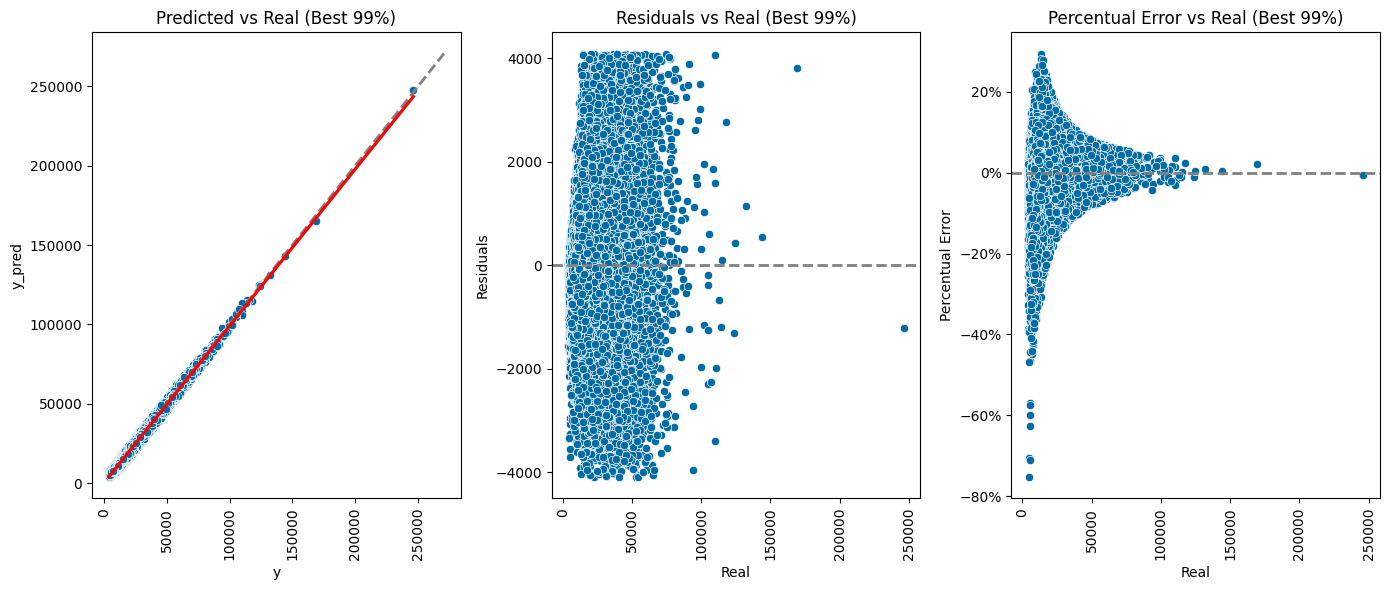

In [46]:
# plot predicted vs real for train set and real scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'train', 'y'],
    df_properties.loc[df_properties['set'] == 'train', 'y_pred'],
    q=99,
    sample_size=100_000
)

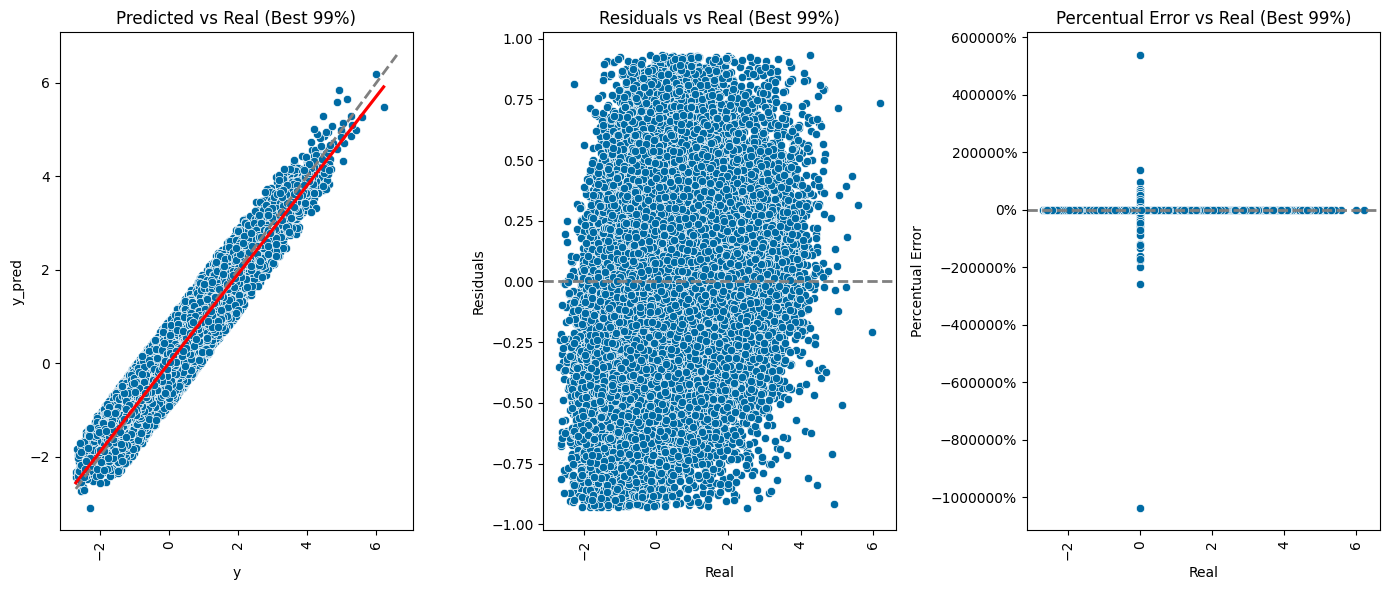

In [47]:
# plot predicted vs real for test set on fitted scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred_fitted'],
    q=99,
    sample_size=100_000
)

### Test

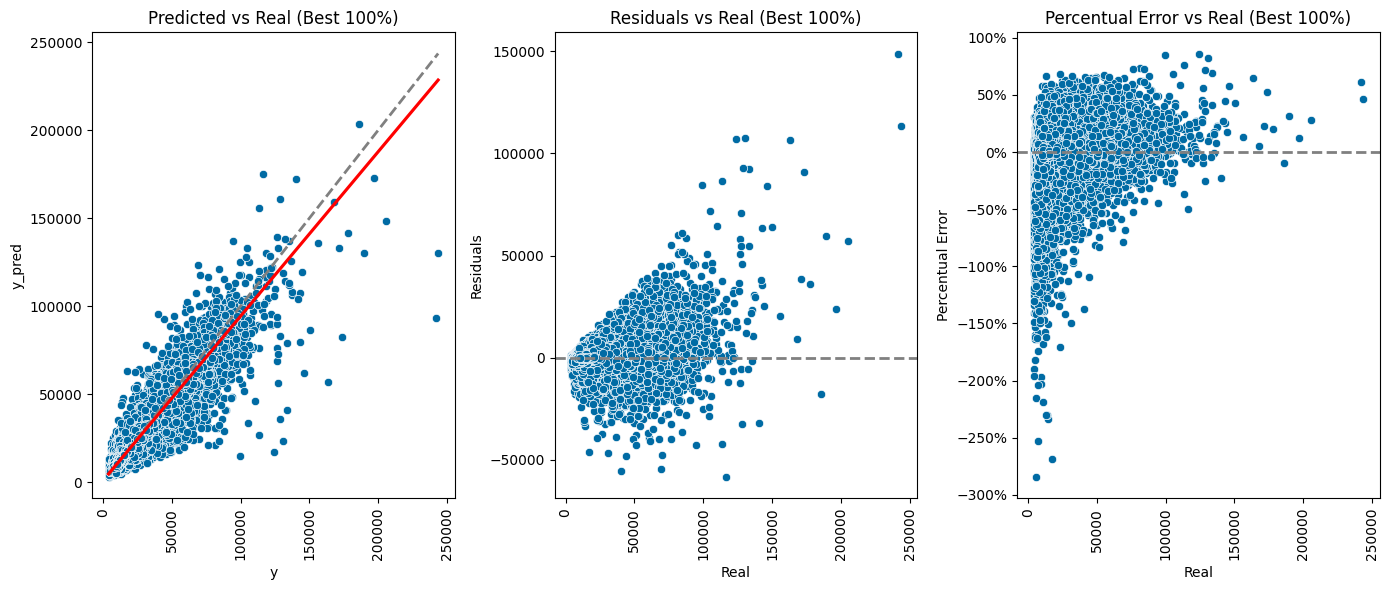

In [51]:
# plot predicted vs real for test set on original scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred'],
    q=100,
    sample_size=np.inf
)

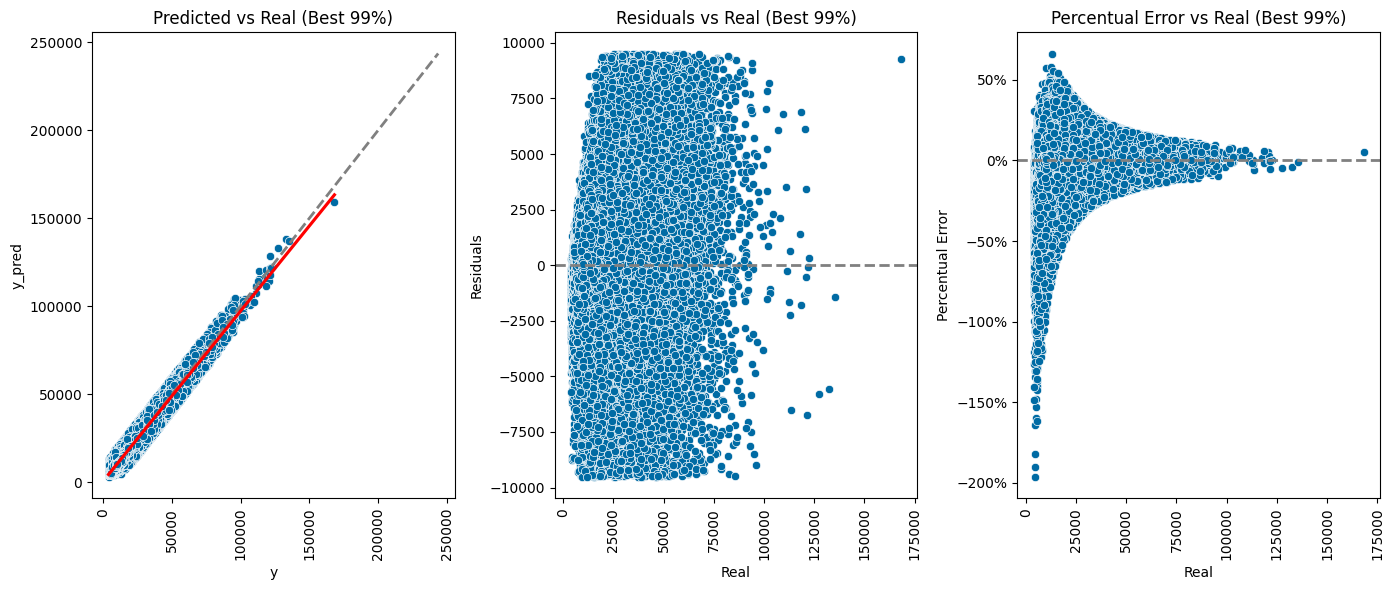

In [53]:
# plot predicted vs real for test set on original scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred'],
    q=99,
    sample_size=np.inf
)

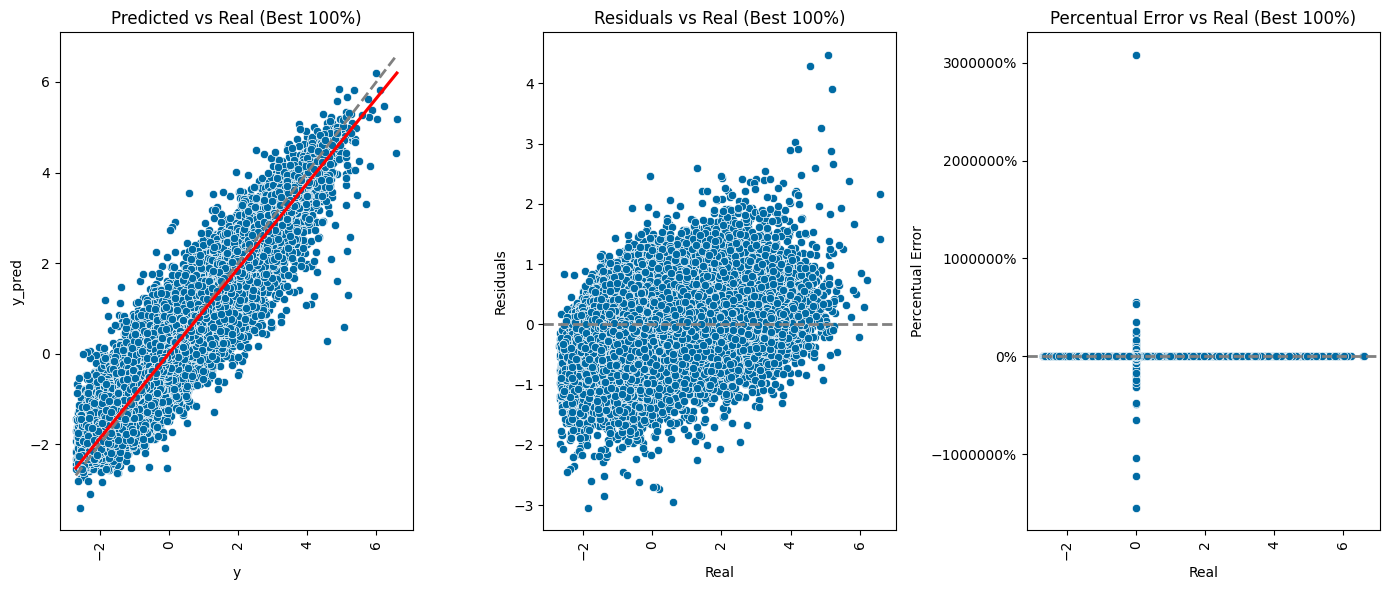

In [52]:
# plot predicted vs real for test set on fitted scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred_fitted'],
    q=100,
    sample_size=np.inf
)

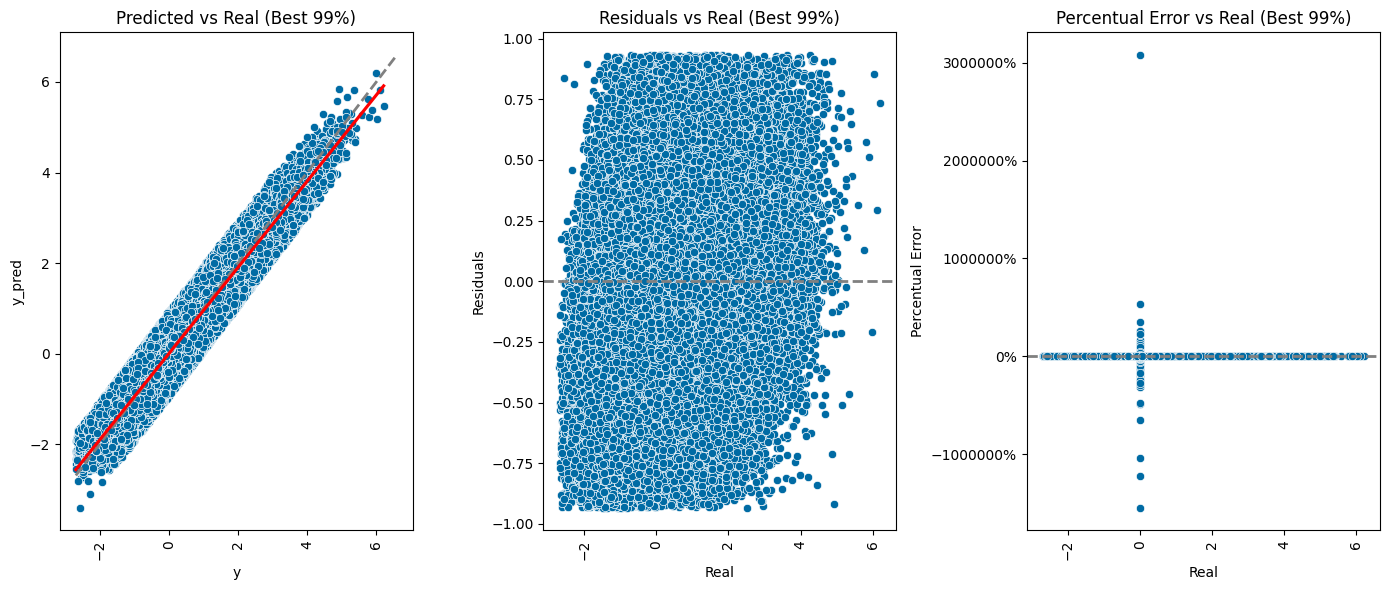

In [54]:
# plot predicted vs real for test set on fitted scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred_fitted'],
    q=99,
    sample_size=np.inf
)

---
# Sandbox

In [15]:
df_properties.columns

Index(['y', 'y_pred', 'y_fitted', 'y_pred_fitted', 'set', 'half_bathrooms',
       'full_bathrooms', 'neighborhood', 'constructor', 'zip_code',
       'age_in_months', 'parking_lots', 'valuation_date', 'property_class_id',
       'controller_id', 'elevator_service_id', 'state_id', 'municipality_id',
       'grantor_id', 'property_type_id', 'valuation_unit_id',
       'valuation_professional_id', 'level', 'bedrooms', 'built_area',
       'saleable_area', 'land_area', 'rentable_units',
       'rentable_units_subject_property', 'current_use', 'price',
       'market_price', 'built_price', 'land_price', 'remaining_useful_life',
       'property_id', 'city_cluster', 'ppsm_comps', 'num_neighbors',
       'distance_to_ocean', 'ocean_label', 'accessory_area', 'ppsm_terrain',
       'hex_id', 'longitude', 'latitude'],
      dtype='object')

In [ ]:
type(pools[label]['y'])

NameError: name 'pools' is not defined

In [ ]:
# see preds
pools['train'].keys()

dict_keys(['dmatrix', 'X', 'y', 'y_original', 'predictions'])

In [ ]:
pools['train']['y_original']

array([ 9950.81967213,  7257.14285714, 36484.84848485, ...,
       26852.6645768 ,  9672.72727273, 45830.50847458])

In [ ]:
transformer.get_transformers()['target'].scale_

array([0.44260513])

In [ ]:
transformer.get_transformers()['target'].mean_

array([9.48384826])

In [ ]:
np.exp(0.44260513 * pools['train']['y'] + 9.48384826)

observation_id
ac771cca-59a9-4c2d-81ac-f6091587bac3     9950.819618
11119915-2970-484b-81d2-ebeb6e35d933     7257.142796
61ac2a5c-4cd6-4348-8742-6c6a29b9fb26    36484.848736
3d4b67fb-6035-4d00-8cb6-eab4e08cddea    14436.363609
b02b035c-efb0-4133-8c62-2a641949211c    10303.797416
                                            ...     
835d5f98-df3d-434c-b531-3ab22ffec0c0    12663.793063
e332290d-372f-46b4-8cb4-6deb930e110a     9426.229452
57ac69c9-6283-4252-9d09-5765a28a7d46    26852.664684
f809822a-d463-4243-a54a-224715142ce4     9672.727217
5ab7a128-a75e-4f58-a631-4a2c1431a141    45830.508890
Length: 1374107, dtype: float64

In [ ]:
pools['train']['y']

observation_id
ac771cca-59a9-4c2d-81ac-f6091587bac3   -0.629089
11119915-2970-484b-81d2-ebeb6e35d933   -1.342295
61ac2a5c-4cd6-4348-8742-6c6a29b9fb26    2.306354
3d4b67fb-6035-4d00-8cb6-eab4e08cddea    0.211605
b02b035c-efb0-4133-8c62-2a641949211c   -0.550334
                                          ...   
835d5f98-df3d-434c-b531-3ab22ffec0c0   -0.084378
e332290d-372f-46b4-8cb4-6deb930e110a   -0.751453
57ac69c9-6283-4252-9d09-5765a28a7d46    1.613791
f809822a-d463-4243-a54a-224715142ce4   -0.693130
5ab7a128-a75e-4f58-a631-4a2c1431a141    2.821605
Length: 1374107, dtype: float64

In [ ]:
pools['train']['X']

,half_bathrooms,full_bathrooms,remaining_useful_life,saleable_area,land_area,parking_lots,quarters_since_first_appraisal,hex_embedding_1_d16_v2,hex_embedding_2_d16_v2,hex_embedding_3_d16_v2,hex_embedding_4_d16_v2,hex_embedding_5_d16_v2,hex_embedding_6_d16_v2,hex_embedding_7_d16_v2,hex_embedding_8_d16_v2,hex_embedding_9_d16_v2,hex_embedding_10_d16_v2,hex_embedding_11_d16_v2,hex_embedding_12_d16_v2,hex_embedding_13_d16_v2,hex_embedding_14_d16_v2,hex_embedding_15_d16_v2,hex_embedding_16_d16_v2,property_type_id_apartment,property_type_id_house,property_type_id_house_on_condominium
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,
ac771cca-59a9-4c2d-81ac-f6091587bac3,0,1,34,61,61,1,3.552632,0.633783,0.043142,0.655791,0.796496,2.572114,-0.858608,0.533800,0.563197,-0.593725,-2.054551,-4.169343,0.763111,-1.482679,0.038740,0.792813,-1.056954,True,False,False
11119915-2970-484b-81d2-ebeb6e35d933,0,1,43,70,102,1,3.607456,0.277621,-2.506492,-3.027083,-0.354941,0.861468,-0.323068,1.394360,1.580939,-1.317493,-0.483832,-0.765858,-0.352476,0.485193,1.862060,-3.492256,0.919060,False,True,False
61ac2a5c-4cd6-4348-8742-6c6a29b9fb26,0,2,69,66,22,1,9.967105,-1.574734,-0.592551,0.108121,-1.642018,1.033004,-0.068187,2.526398,0.683552,-0.554086,-1.646644,-2.215271,0.839841,-3.586264,-0.041413,-0.644456,-0.318226,True,False,False
3d4b67fb-6035-4d00-8cb6-eab4e08cddea,0,1,43,55,52,1,6.217105,1.082876,-1.488629,2.138569,0.255607,1.017570,-1.404511,-1.206679,-0.395506,-0.419243,-0.772322,-1.898879,1.198922,-1.607071,2.955249,-2.021534,-1.501223,False,False,True
b02b035c-efb0-4133-8c62-2a641949211c,0,2,53,79,90,1,11.008772,0.980456,0.987714,0.411900,-0.559730,0.257390,-1.047156,1.050302,0.117700,-2.013388,0.016823,-0.581395,2.663196,-4.079000,0.624948,-1.160834,1.577138,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835d5f98-df3d-434c-b531-3ab22ffec0c0,1,2,70,116,90,1,5.164474,0.671744,-1.691664,-3.300608,0.434774,1.296298,0.816887,1.979480,0.304823,-0.259721,-0.005673,-1.825814,2.505251,-0.640285,1.967032,0.120273,0.630796,False,False,True
e332290d-372f-46b4-8cb4-6deb930e110a,0,1,70,61,128,1,5.010965,0.325305,-0.461028,-0.905249,1.238320,2.452415,-0.753438,-0.011188,0.369901,-1.726243,-1.480153,-0.868424,1.903770,-0.825175,0.007101,-1.727907,3.729228,False,True,False
57ac69c9-6283-4252-9d09-5765a28a7d46,1,4,80,319,308,3,15.372807,-0.295680,1.437505,-1.288257,-0.822294,1.685256,-2.466023,2.431737,0.519390,-0.609053,-2.689914,-1.049502,1.143693,-1.288945,1.475106,-1.562989,-0.455712,False,False,True


In [ ]:
pools['train']['X'].columns

Index(['half_bathrooms', 'full_bathrooms', 'remaining_useful_life',
       'saleable_area', 'land_area', 'parking_lots',
       'quarters_since_first_appraisal', 'hex_embedding_1_d16_v2',
       'hex_embedding_2_d16_v2', 'hex_embedding_3_d16_v2',
       'hex_embedding_4_d16_v2', 'hex_embedding_5_d16_v2',
       'hex_embedding_6_d16_v2', 'hex_embedding_7_d16_v2',
       'hex_embedding_8_d16_v2', 'hex_embedding_9_d16_v2',
       'hex_embedding_10_d16_v2', 'hex_embedding_11_d16_v2',
       'hex_embedding_12_d16_v2', 'hex_embedding_13_d16_v2',
       'hex_embedding_14_d16_v2', 'hex_embedding_15_d16_v2',
       'hex_embedding_16_d16_v2', 'property_type_id_apartment',
       'property_type_id_house', 'property_type_id_house_on_condominium',
       'y_pred', 'y', 'y_pred_fitted', 'y_fitted'],
      dtype='object')

In [ ]:
# look
pools['train']['X'].head(5)

,half_bathrooms,full_bathrooms,remaining_useful_life,saleable_area,land_area,parking_lots,quarters_since_first_appraisal,hex_embedding_1_d16_v2,hex_embedding_2_d16_v2,hex_embedding_3_d16_v2,hex_embedding_4_d16_v2,hex_embedding_5_d16_v2,hex_embedding_6_d16_v2,hex_embedding_7_d16_v2,hex_embedding_8_d16_v2,hex_embedding_9_d16_v2,hex_embedding_10_d16_v2,hex_embedding_11_d16_v2,hex_embedding_12_d16_v2,hex_embedding_13_d16_v2,hex_embedding_14_d16_v2,hex_embedding_15_d16_v2,hex_embedding_16_d16_v2,property_type_id_apartment,property_type_id_house,property_type_id_house_on_condominium,y_pred,y,y_pred_fitted,y_fitted
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ac771cca-59a9-4c2d-81ac-f6091587bac3,0,1,34,61,61,1,3.552632,0.633783,0.043142,0.655791,0.796496,2.572114,-0.858608,0.533800,0.563197,-0.593725,-2.054551,-4.169343,0.763111,-1.482679,0.038740,0.792813,-1.056954,True,False,False,9433.436523,9950.819672,-0.749726,-0.629089
11119915-2970-484b-81d2-ebeb6e35d933,0,1,43,70,102,1,3.607456,0.277621,-2.506492,-3.027083,-0.354941,0.861468,-0.323068,1.394360,1.580939,-1.317493,-0.483832,-0.765858,-0.352476,0.485193,1.862060,-3.492256,0.919060,False,True,False,7560.211914,7257.142857,-1.249858,-1.342295
61ac2a5c-4cd6-4348-8742-6c6a29b9fb26,0,2,69,66,22,1,9.967105,-1.574734,-0.592551,0.108121,-1.642018,1.033004,-0.068187,2.526398,0.683552,-0.554086,-1.646644,-2.215271,0.839841,-3.586264,-0.041413,-0.644456,-0.318226,True,False,False,33727.996094,36484.848485,2.128840,2.306354
3d4b67fb-6035-4d00-8cb6-eab4e08cddea,0,1,43,55,52,1,6.217105,1.082876,-1.488629,2.138569,0.255607,1.017570,-1.404511,-1.206679,-0.395506,-0.419243,-0.772322,-1.898879,1.198922,-1.607071,2.955249,-2.021534,-1.501223,False,False,True,11887.272461,14436.363636,-0.227346,0.211605
b02b035c-efb0-4133-8c62-2a641949211c,0,2,53,79,90,1,11.008772,0.980456,0.987714,0.411900,-0.559730,0.257390,-1.047156,1.050302,0.117700,-2.013388,0.016823,-0.581395,2.663196,-4.079000,0.624948,-1.160834,1.577138,False,True,False,11435.018555,10303.797468,-0.314983,-0.550334


In [14]:
%whos

Variable                   Type         Data/Info
-------------------------------------------------
COLS_PROPERTIES            list         n=42
DIR_DATA                   str          ../../data
DIR_MODELS                 str          ../../models
DIR_RESULTS                str          ../../results
FILE_PROPERTIES            str          ../../data/clean/properties_shif.parquet
FeatureTransformer         type         <class '__main__.FeatureTransformer'>
PowerTransformer           type         <class 'sklearn.preproces<...>._data.PowerTransformer'>
StandardScaler             type         <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TODAY                      Timestamp    2025-04-12 14:11:40.928579
apply_transformation       function     <function apply_transformation at 0x308ed2950>
config_model               dict         n=7
df_properties              DataFrame                             <...>908483 rows x 46 columns]
feature_engineering        function     <function fe

In [ ]:
# columns
df_properties.columns.to_list()

['y',
 'y_pred',
 'y_fitted',
 'y_pred_fitted',
 'set',
 'half_bathrooms',
 'full_bathrooms',
 'property_class_more_common_in_area',
 'neighborhood',
 'constructor',
 'zip_code',
 'age_in_months',
 'parking_lots',
 'valuation_date',
 'potable_water_service_id',
 'lighting_service_id',
 'sidewalk_id',
 'project_quality_id',
 'property_class_id',
 'conservation_status_id',
 'controller_id',
 'elevator_service_id',
 'state_id',
 'equipment_id',
 'curb_id',
 'infrastructure_service_id',
 'road_materials_id',
 'municipality_id',
 'grantor_id',
 'urban_proximity_id',
 'water_collection_service_id',
 'electrical_supply_service_id',
 'telephone_service_supply_id',
 'property_type_id',
 'public_transportation_service_id',
 'valuation_unit_id',
 'valuation_professional_id',
 'level',
 'total_levels',
 'purpose_of_appraisal',
 'bedrooms',
 'built_area',
 'saleable_area',
 'land_area',
 'rentable_units',
 'rentable_units_subject_property',
 'current_use',
 'market_price',
 'price',
 'built_price',